In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
from probesLocation import probesLocation

In [118]:
def getProbeCountry(probeId):  # pegar país
    return probesLocation.get(probeId, {}).get('país', f'ID {probeId} não encontrado')

def getProbeContinent(probeId):  # pegar continente
    return probesLocation.get(probeId, {}).get('continente', f'ID {probeId} não encontrado')

def getLatency(probeInfo):
    latencias = []
    for hop in probeInfo['result']:
        latenciasHop = [item['rtt'] for item in hop['result'] if 'rtt' in item]
        latencias.append(latenciasHop)
    return latencias

In [119]:
pais = []
cod = []

# pega os diferentes paises

In [120]:
pais = []
cod = []
probeGroupedInfo = {}

with open('jsonFiles/GoogleNews.json', 'r') as jsonFile:
    resultInfo = json.load(jsonFile)
for probeInfo in resultInfo['info']:
    if probeInfo["destination_ip_responded"]:  # Verifica se a probe chegou ao destino
        probeJson = {
            'probeId': probeInfo['prb_id'],
            'destino': probeInfo['dst_name'],
            'pais': getProbeCountry(probeInfo['prb_id']),
            'continente': getProbeContinent(probeInfo['prb_id']),
            'latencia': getLatency(probeInfo),
            'quantidadeSaltos': len(probeInfo['result']),
            'data': datetime.fromtimestamp(probeInfo['stored_timestamp']).strftime('%Y-%m-%d %H:%M:%S')
        }
        
        if probeJson['probeId'] in probeGroupedInfo:
            probeGroupedInfo[probeJson['probeId']].append(probeJson['pais'])
        else:
            probeGroupedInfo[probeJson['probeId']] = [probeJson['pais']]

for x in probeGroupedInfo:
    if x not in cod:
        cod.append(x)
        pais.append(probeGroupedInfo[x][0])
paises = list(set(pais))

In [121]:
pais = paises[0] # id do pais que voce quer as probes

# Pega os id das probes por pais

In [122]:
probeGroupedInfo = {}
with open('jsonFiles/GoogleNews.json', 'r') as jsonFile:
    resultInfo = json.load(jsonFile)
for probeInfo in resultInfo['info']:
    if probeInfo["destination_ip_responded"] and getProbeCountry(probeInfo['prb_id']) == pais: 
        probeJson = {
            'probeId': probeInfo['prb_id'],
            'destino': probeInfo['dst_name'],
            'pais': getProbeCountry(probeInfo['prb_id']),
            'continente': getProbeContinent(probeInfo['prb_id']),
            'latencia': getLatency(probeInfo),
            'quantidadeSaltos': len(probeInfo['result']),
            'data': datetime.fromtimestamp(probeInfo['stored_timestamp']).strftime('%Y-%m-%d %H:%M:%S')
        }
        
        if probeJson['probeId'] in probeGroupedInfo:
            probeGroupedInfo[probeJson['probeId']].append(probeJson)
        else:
            probeGroupedInfo[probeJson['probeId']] = [probeJson]
ids = [x for x in probeGroupedInfo]

In [123]:
id = ids[0] # de 0 a 3 qual probe por pais voce quer por pais

# Latência por Probe

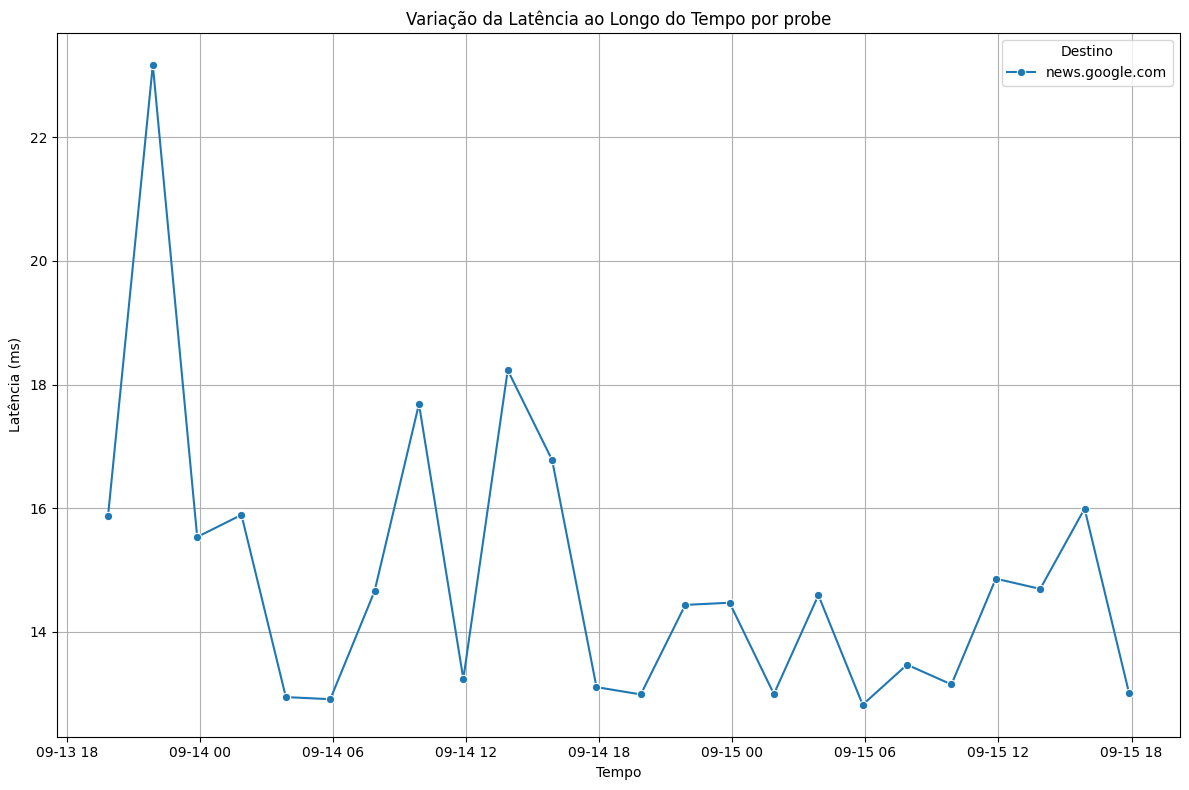

In [129]:
ids
data = probeGroupedInfo[id]
rows = []

# Iterar sobre cada medição
for measurement in data:
    probe_id = measurement['probeId']
    destination = measurement['destino']
    country = measurement['pais']
    continent = measurement['continente']
    timestamp = measurement['data']
    
    for hop_num, hop_latencies in enumerate(measurement['latencia'], start=1):
        # Ignorar saltos vazios
        if hop_latencies:
            for rtt in hop_latencies:
                rows.append({
                    'probe_id': probe_id,
                    'destination': destination,
                    'country': country,
                    'continent': continent,
                    'timestamp': timestamp,
                    'hop': hop_num,
                    'rtt': rtt
                })

# Criar o DataFrame
df = pd.DataFrame(rows)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plotar a variação da latência ao longo do tempo por destino
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='timestamp', y='rtt', hue='destination', marker='o', errorbar=None)
plt.title('Variação da Latência ao Longo do Tempo por probe')
plt.xlabel('Tempo')
plt.ylabel('Latência (ms)')
plt.legend(title='Destino', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


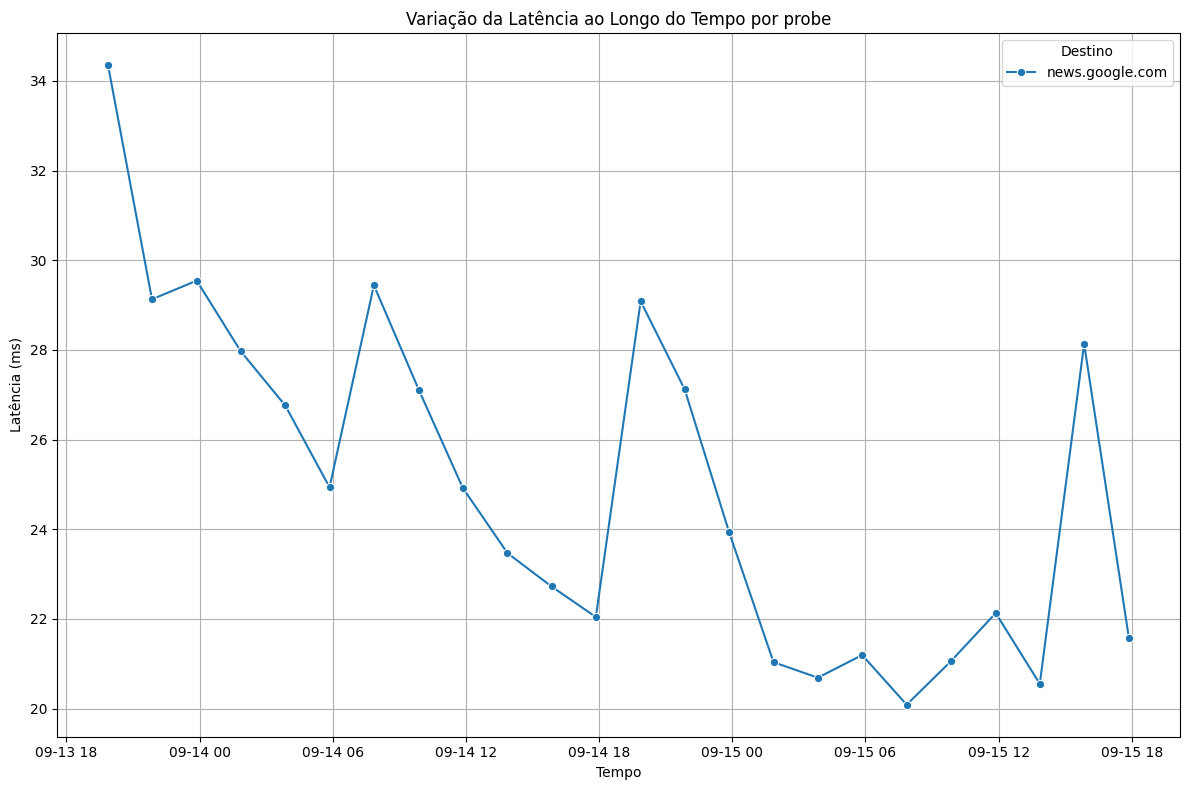

In [131]:
id = ids[1]
data = probeGroupedInfo[id]
rows = []

# Iterar sobre cada medição
for measurement in data:
    probe_id = measurement['probeId']
    destination = measurement['destino']
    country = measurement['pais']
    continent = measurement['continente']
    timestamp = measurement['data']
    
    for hop_num, hop_latencies in enumerate(measurement['latencia'], start=1):
        # Ignorar saltos vazios
        if hop_latencies:
            for rtt in hop_latencies:
                rows.append({
                    'probe_id': probe_id,
                    'destination': destination,
                    'country': country,
                    'continent': continent,
                    'timestamp': timestamp,
                    'hop': hop_num,
                    'rtt': rtt
                })

# Criar o DataFrame
df = pd.DataFrame(rows)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plotar a variação da latência ao longo do tempo por destino
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='timestamp', y='rtt', hue='destination', marker='o', errorbar=None)
plt.title('Variação da Latência ao Longo do Tempo por probe')
plt.xlabel('Tempo')
plt.ylabel('Latência (ms)')
plt.legend(title='Destino', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Quantidade de saltos por Probe

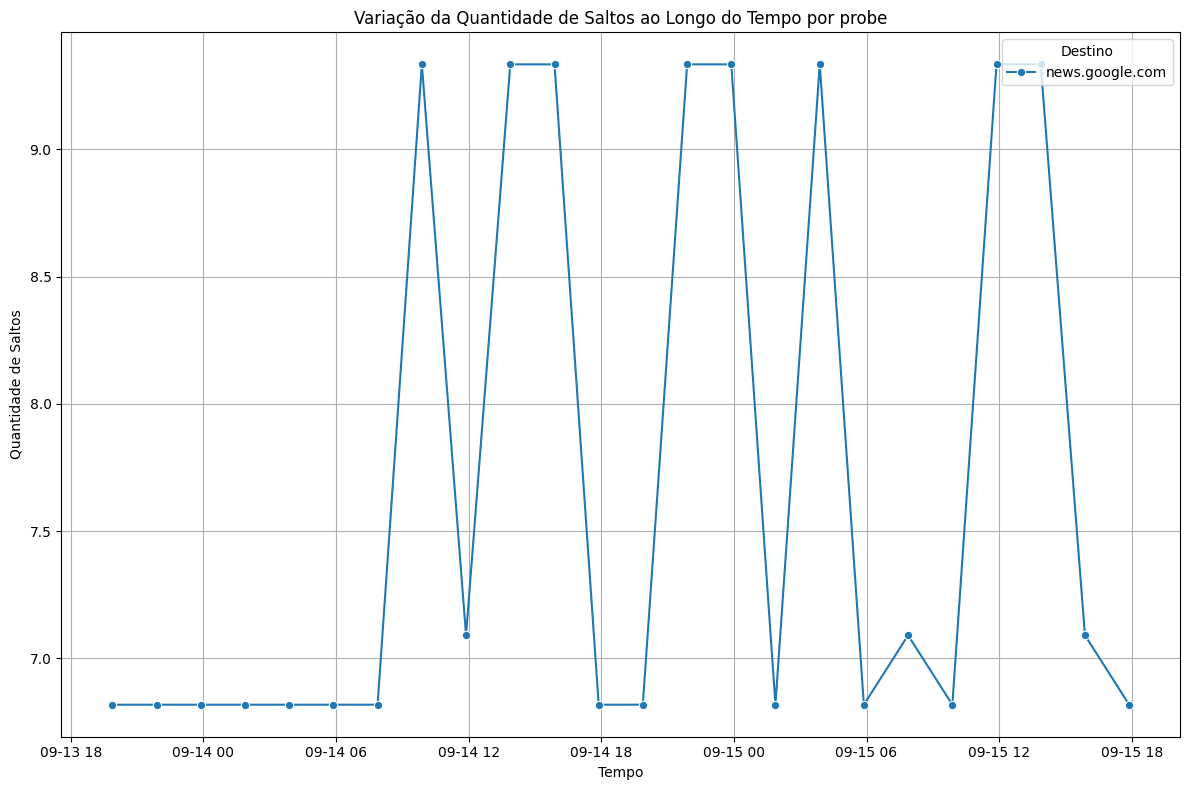

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = probeGroupedInfo[ids[2]]  # de 0 a 3 qual probe por país você quer

rows = []

# Iterar sobre cada medição
for measurement in data:
    probe_id = measurement['probeId']
    destination = measurement['destino']
    country = measurement['pais']
    continent = measurement['continente']
    timestamp = measurement['data']
    
    for hop_num, hop_latencies in enumerate(measurement['latencia'], start=1):
        # Ignorar saltos vazios
        if hop_latencies:
            for rtt in hop_latencies:
                rows.append({
                    'probe_id': probe_id,
                    'destination': destination,
                    'country': country,
                    'continent': continent,
                    'timestamp': timestamp,
                    'hop': hop_num
                })

# Criar o DataFrame
df = pd.DataFrame(rows)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plotar a variação da quantidade de saltos ao longo do tempo por destino
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='timestamp', y='hop', hue='destination', marker='o', errorbar=None)
plt.title('Variação da Quantidade de Saltos ao Longo do Tempo por probe')
plt.xlabel('Tempo')
plt.ylabel('Quantidade de Saltos')
plt.legend(title='Destino', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Correlação entre a latência com o número de saltos

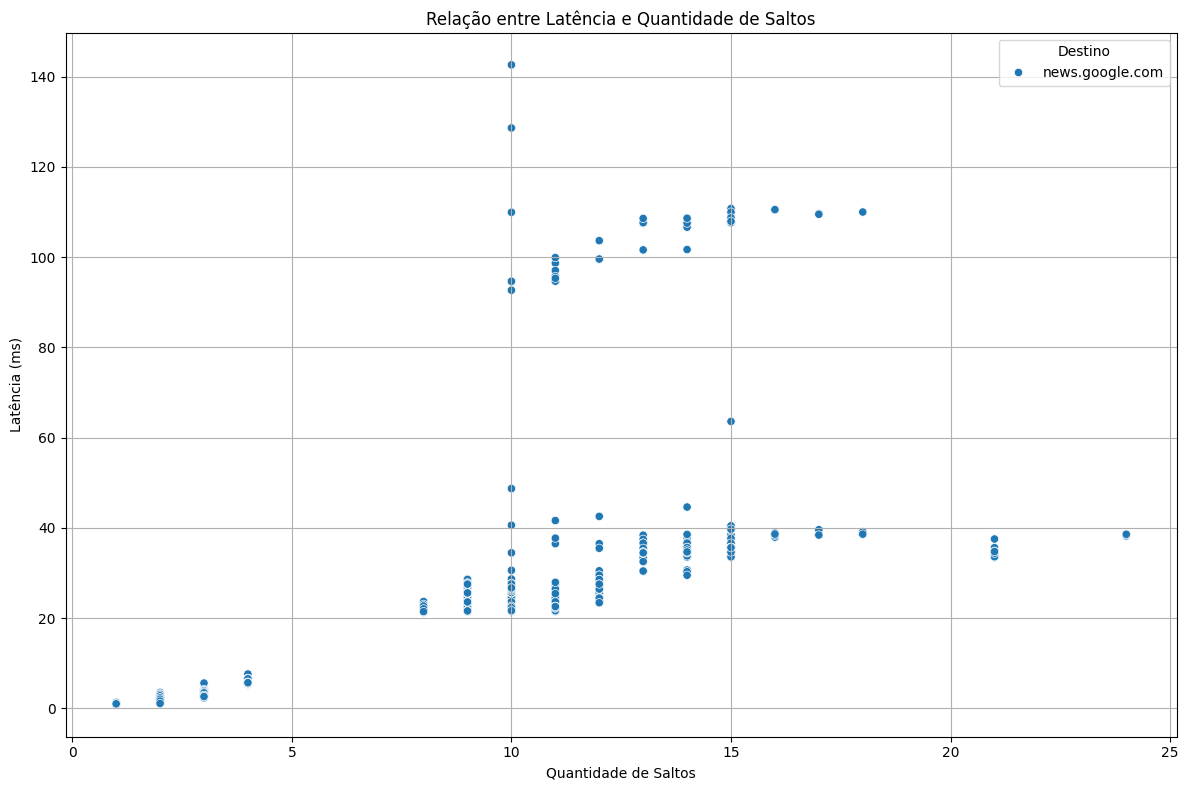

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = probeGroupedInfo[ids[1]]  # de 0 a 3 qual probe por país você quer

rows = []

# Iterar sobre cada medição
for measurement in data:
    probe_id = measurement['probeId']
    destination = measurement['destino']
    country = measurement['pais']
    continent = measurement['continente']
    timestamp = measurement['data']
    
    for hop_num, hop_latencies in enumerate(measurement['latencia'], start=1):
        # Ignorar saltos vazios
        if hop_latencies:
            for rtt in hop_latencies:
                rows.append({
                    'probe_id': probe_id,
                    'destination': destination,
                    'country': country,
                    'continent': continent,
                    'timestamp': timestamp,
                    'hop': hop_num,
                    'rtt': rtt
                })

# Criar o DataFrame
df = pd.DataFrame(rows)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plotar a relação entre latência e quantidade de saltos
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='hop', y='rtt', hue='destination', marker='o')
plt.title('Relação entre Latência e Quantidade de Saltos')
plt.xlabel('Quantidade de Saltos')
plt.ylabel('Latência (ms)')
plt.legend(title='Destino', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_36994/597357278.py:80: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H', on='timestamp').agg({


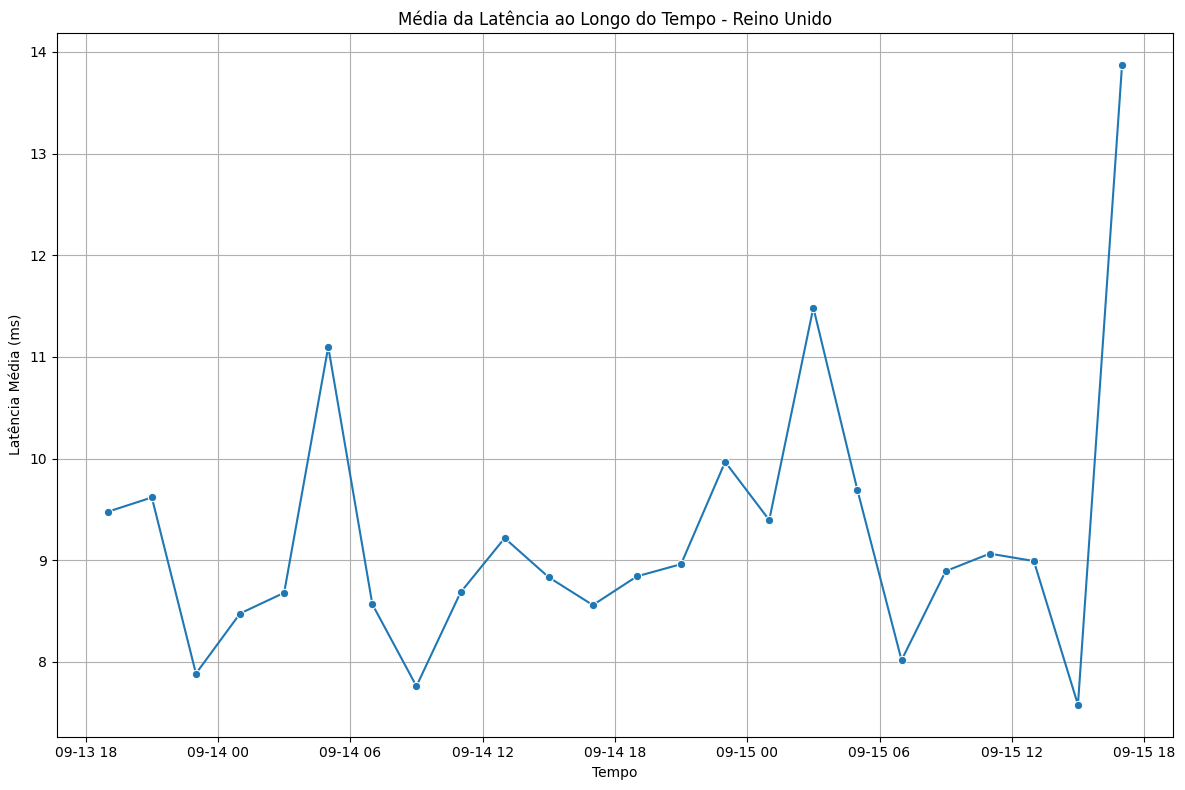

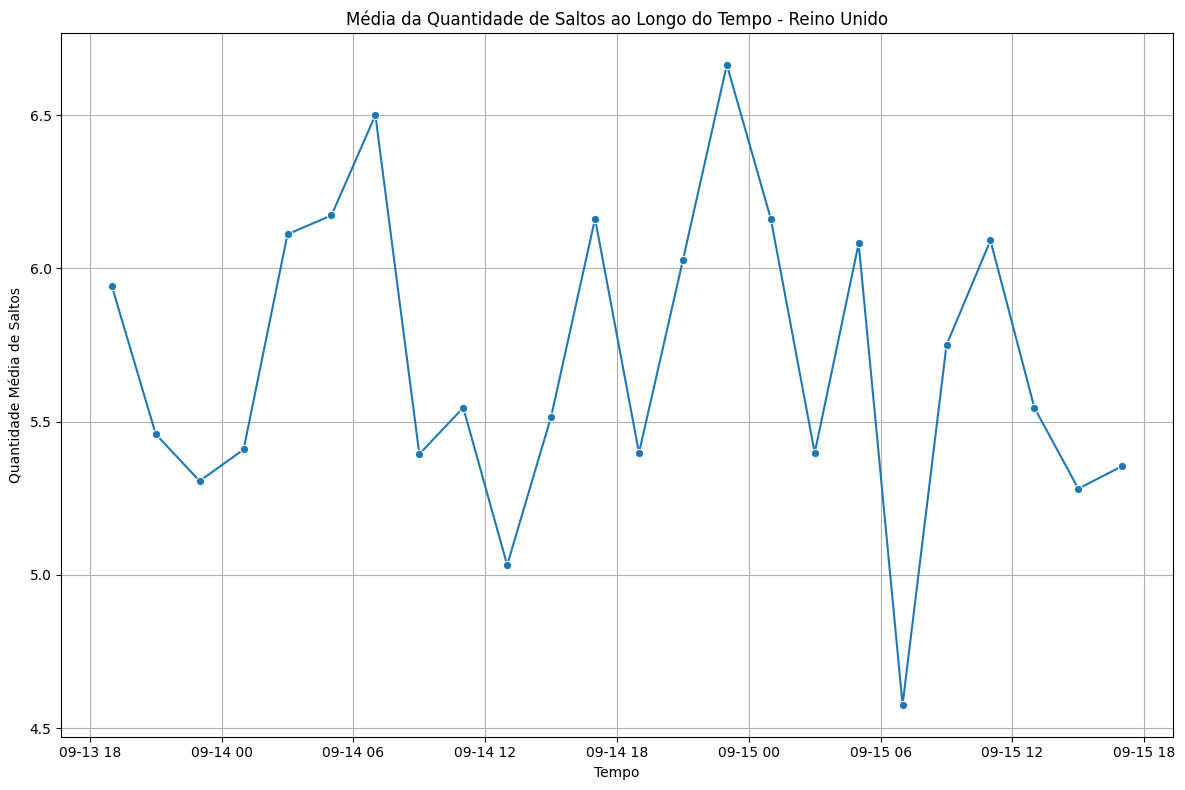

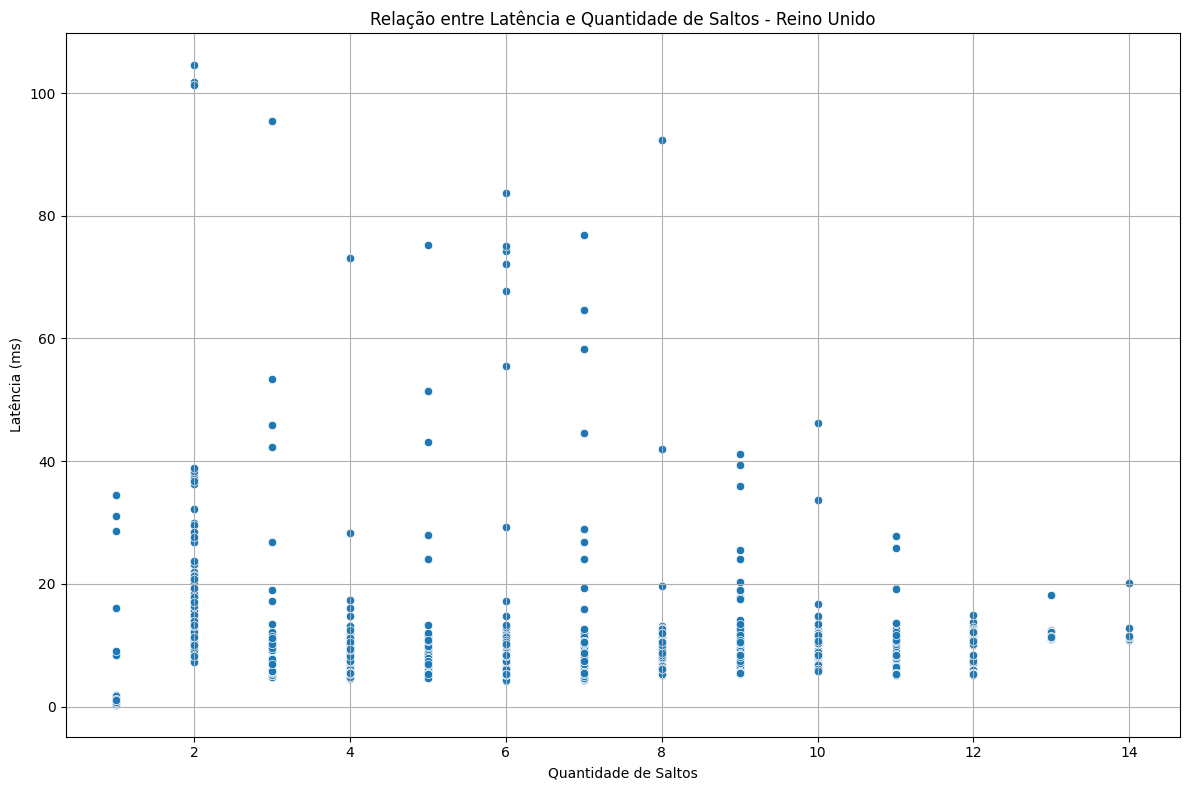

/tmp/ipykernel_36994/597357278.py:80: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H', on='timestamp').agg({


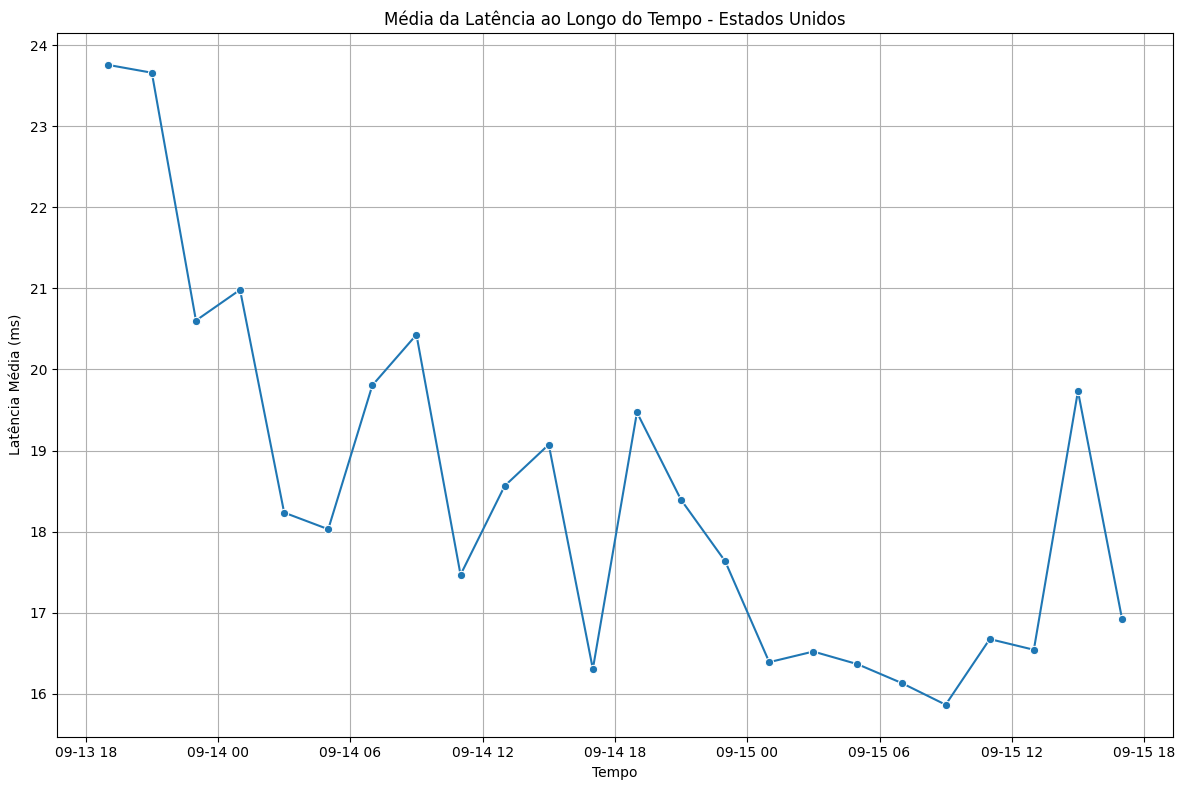

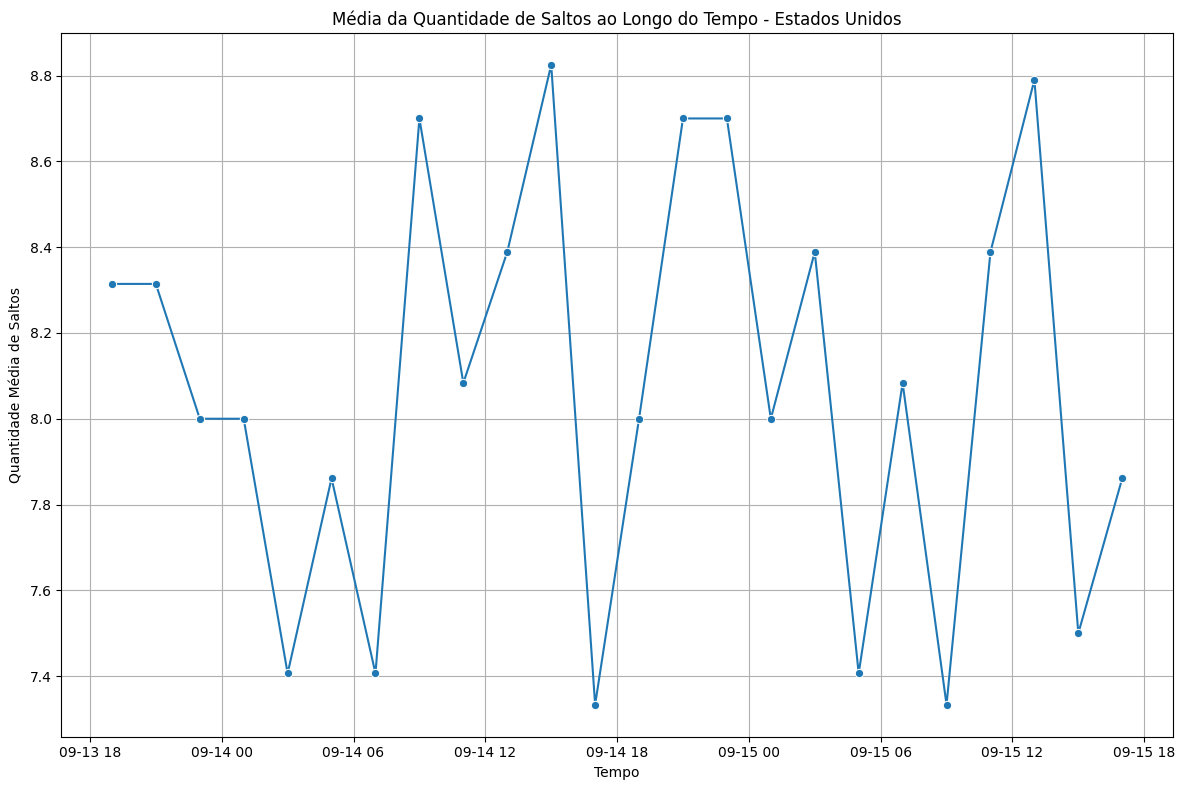

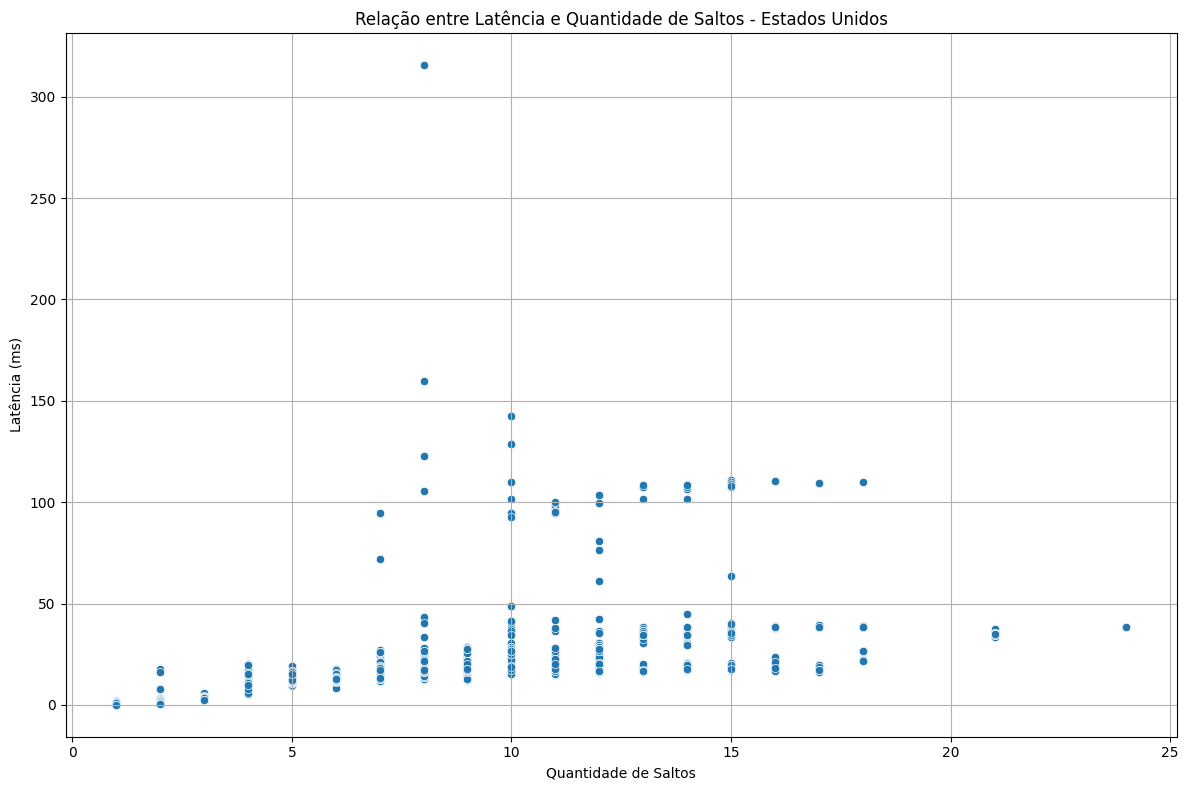

/tmp/ipykernel_36994/597357278.py:80: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H', on='timestamp').agg({


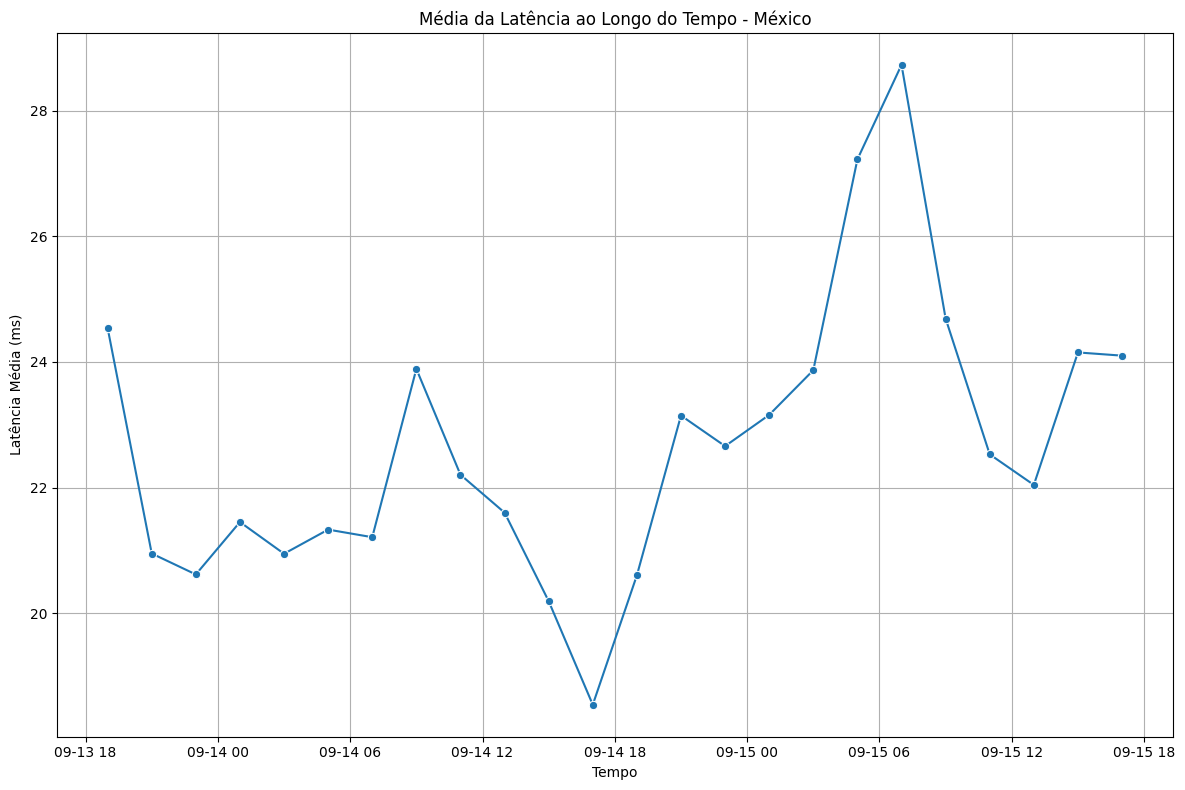

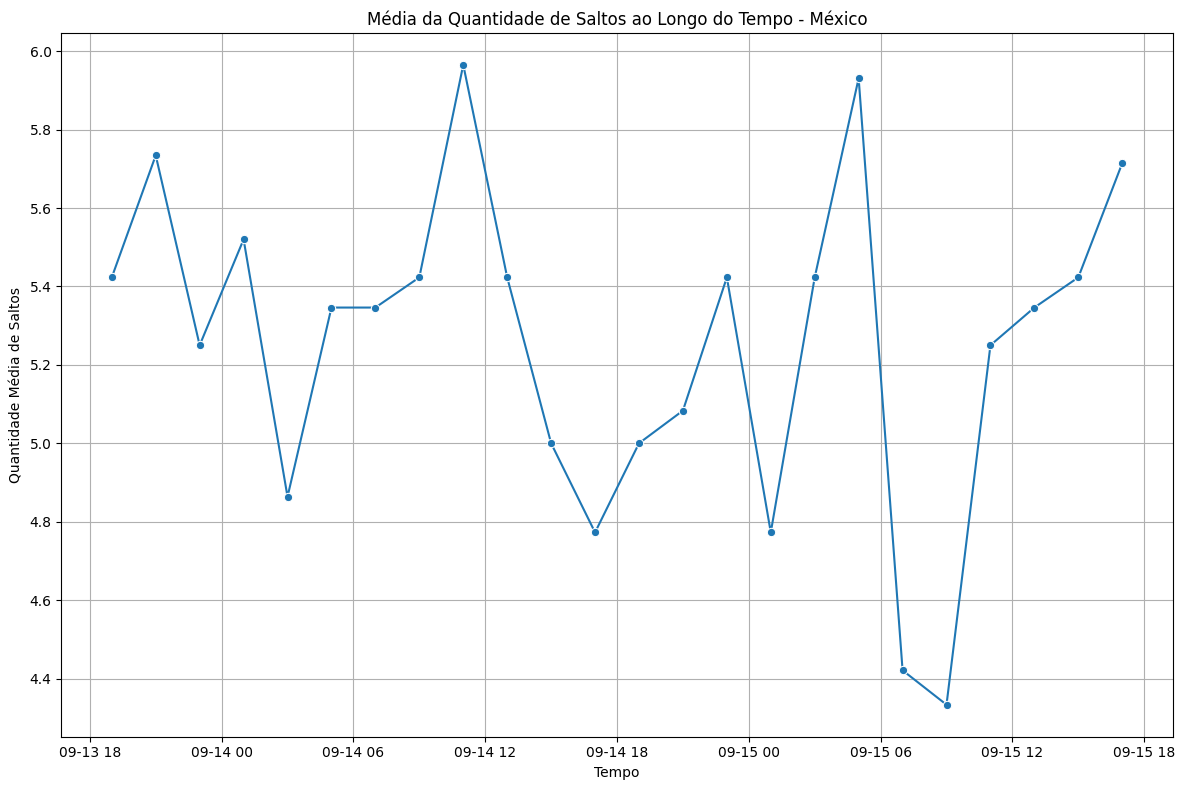

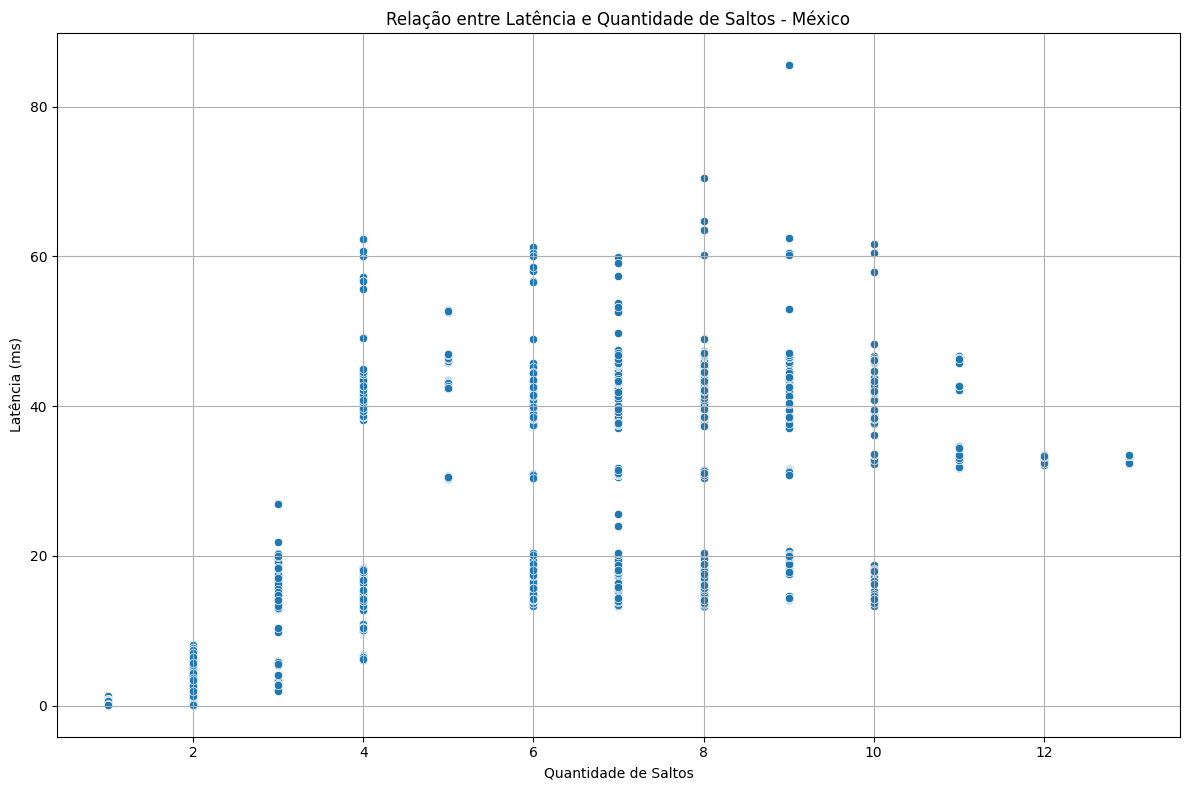

/tmp/ipykernel_36994/597357278.py:80: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H', on='timestamp').agg({


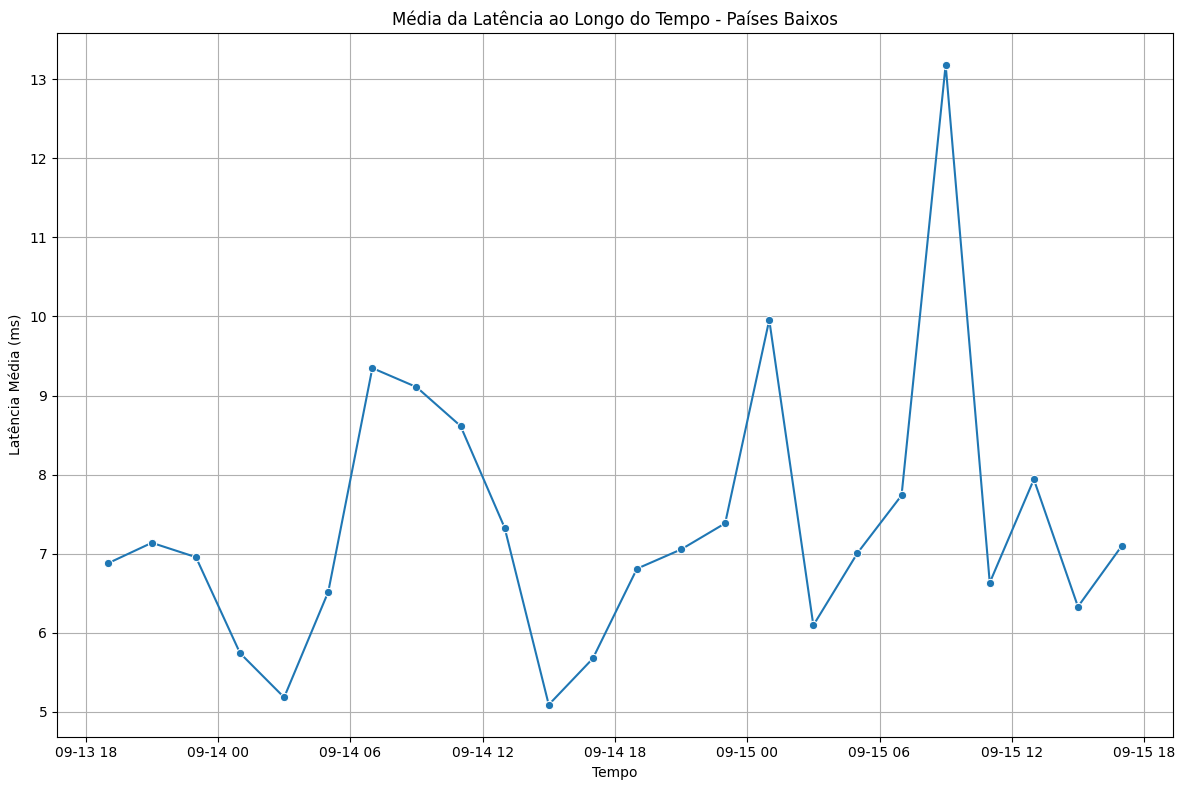

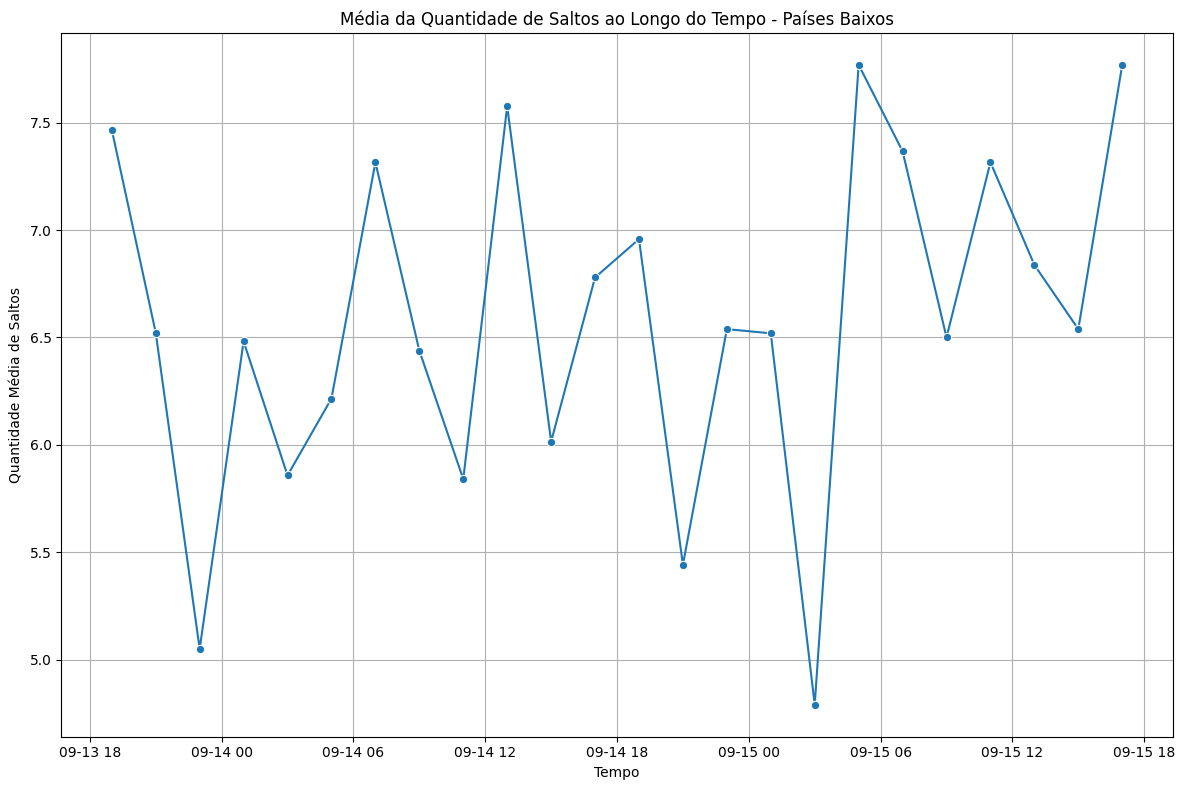

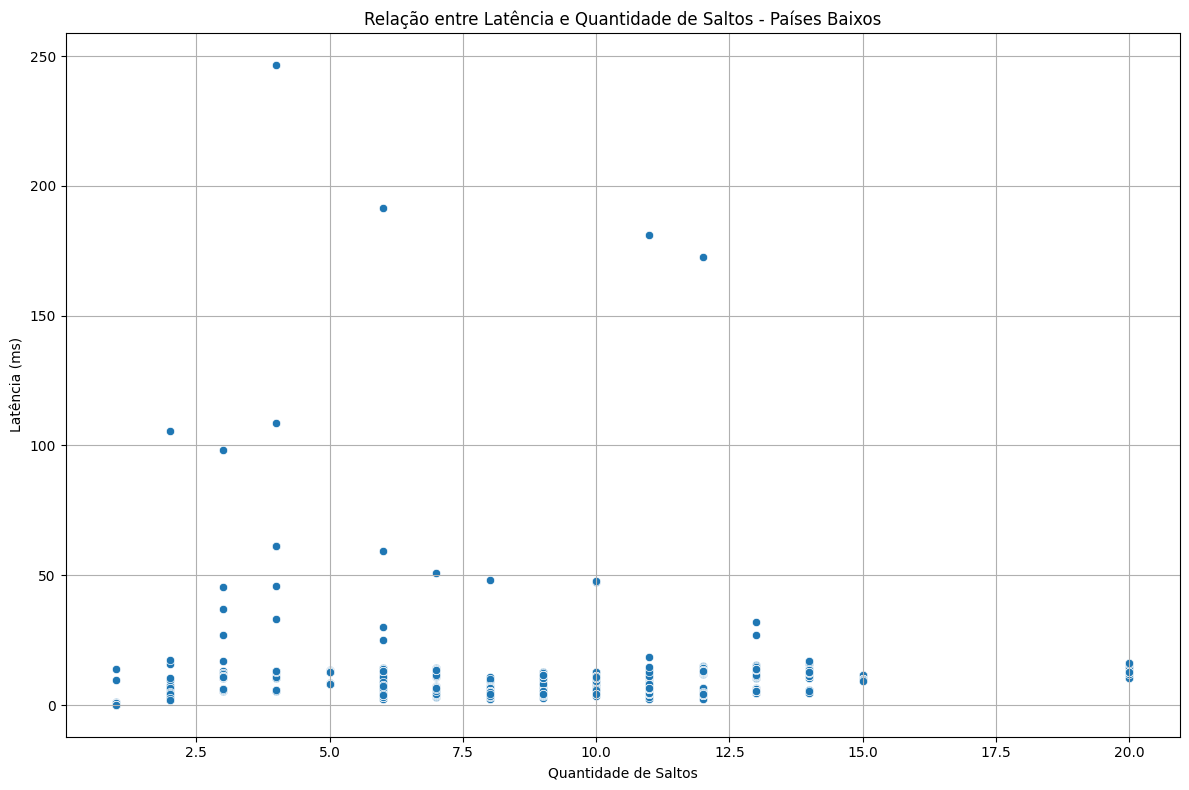

/tmp/ipykernel_36994/597357278.py:80: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H', on='timestamp').agg({


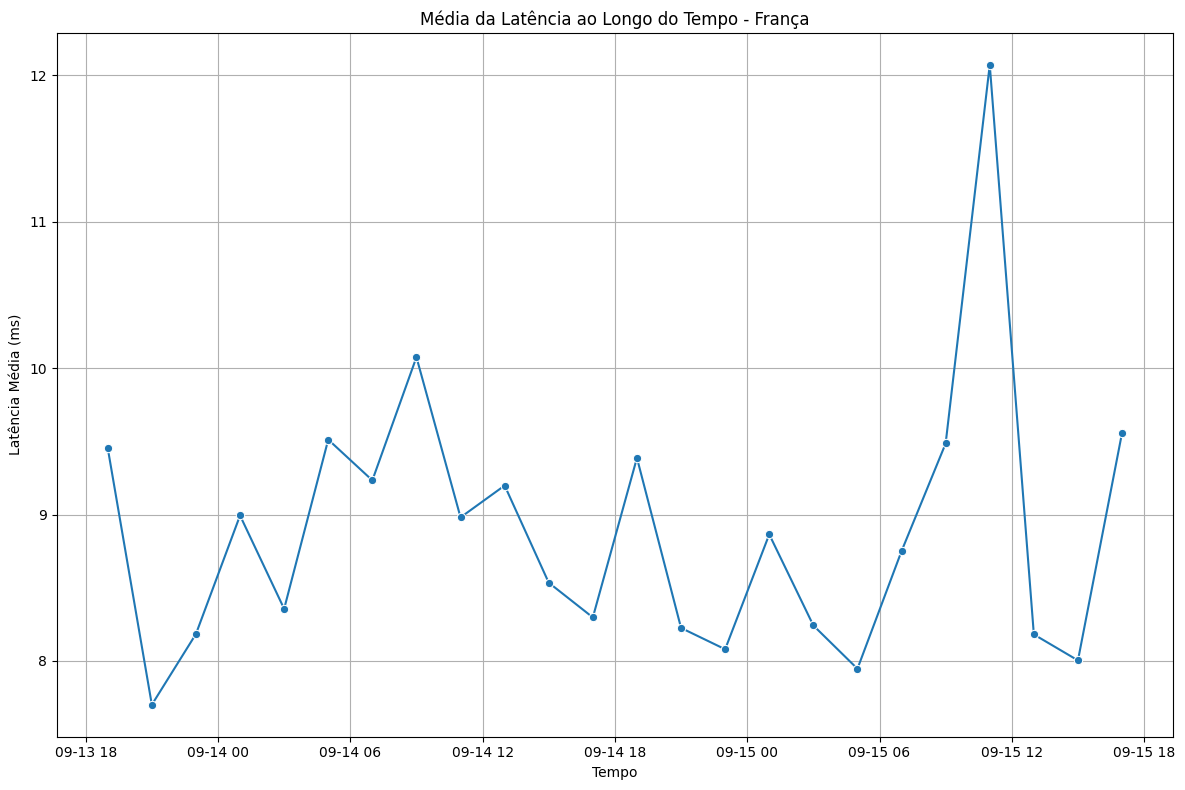

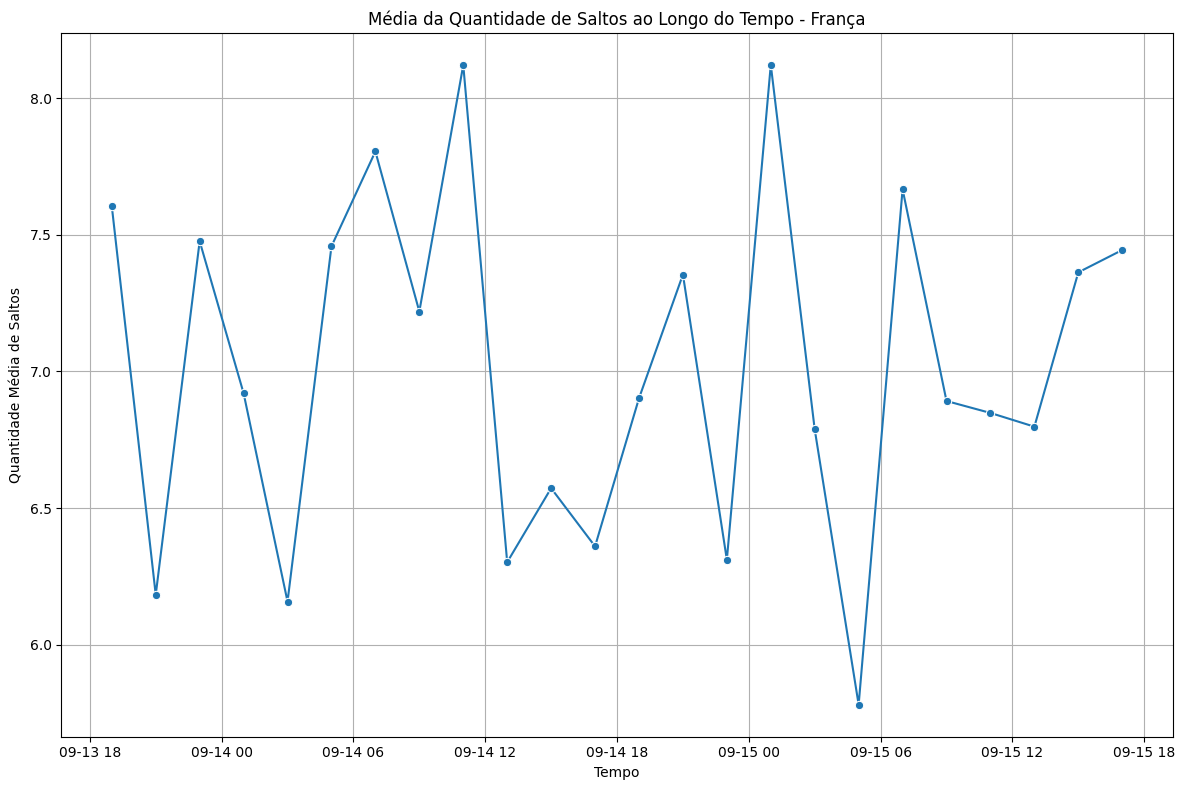

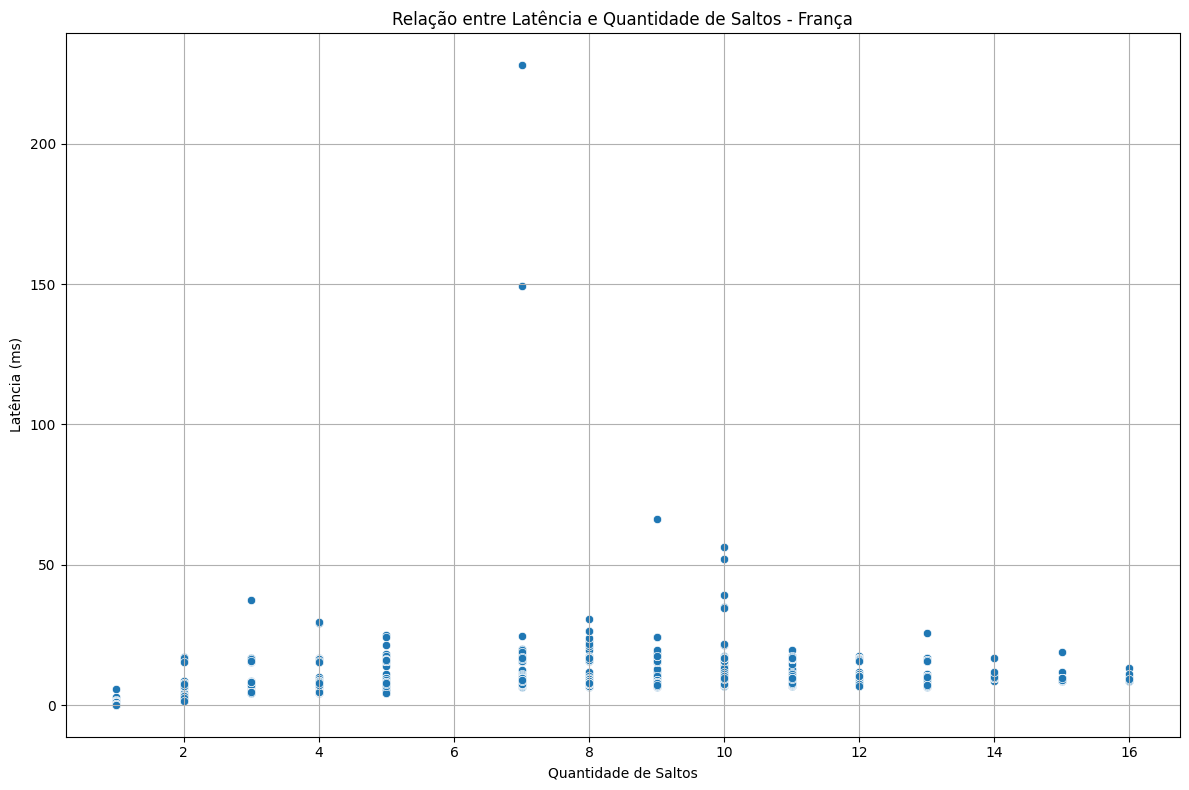

/tmp/ipykernel_36994/597357278.py:80: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H', on='timestamp').agg({


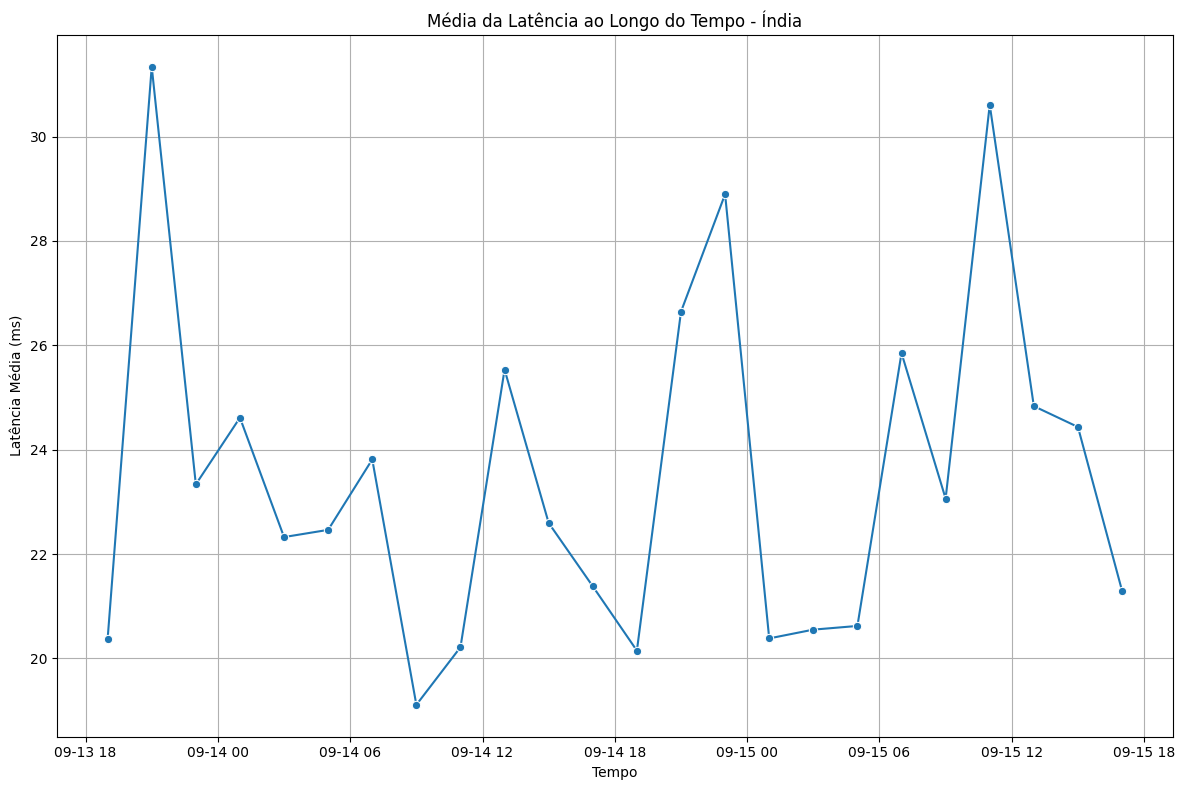

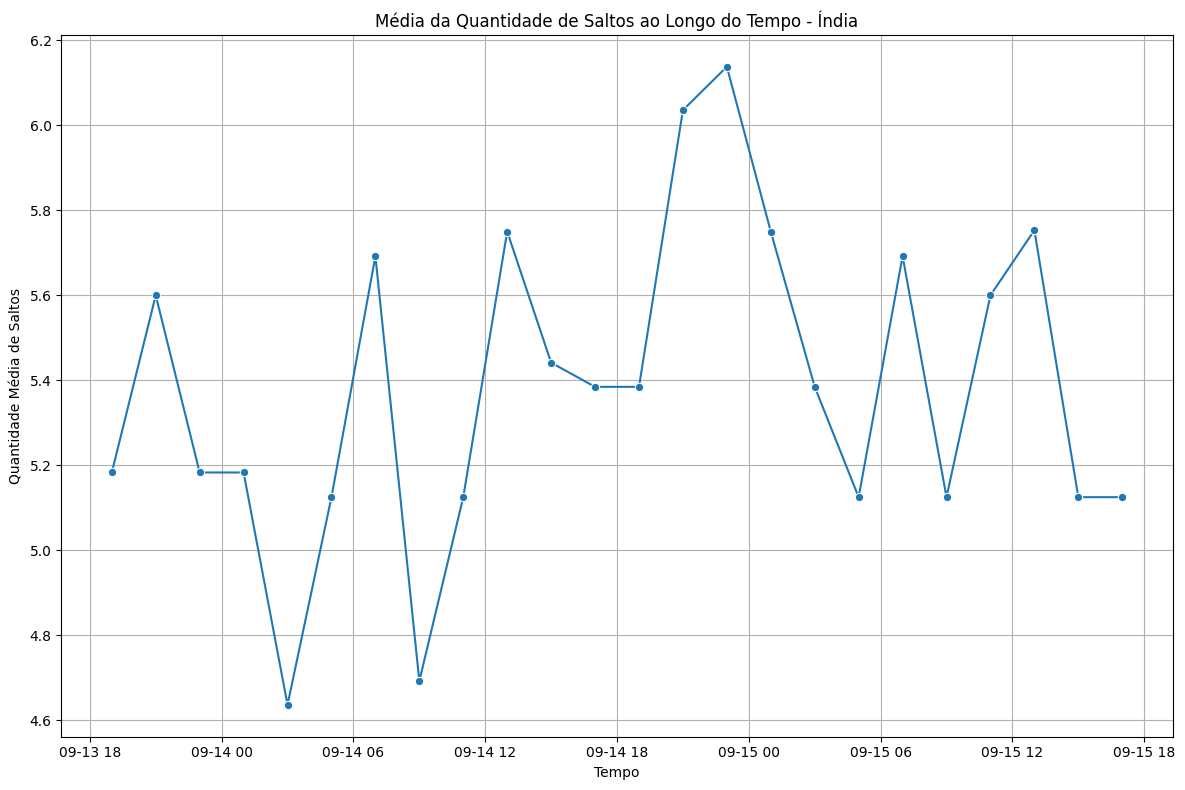

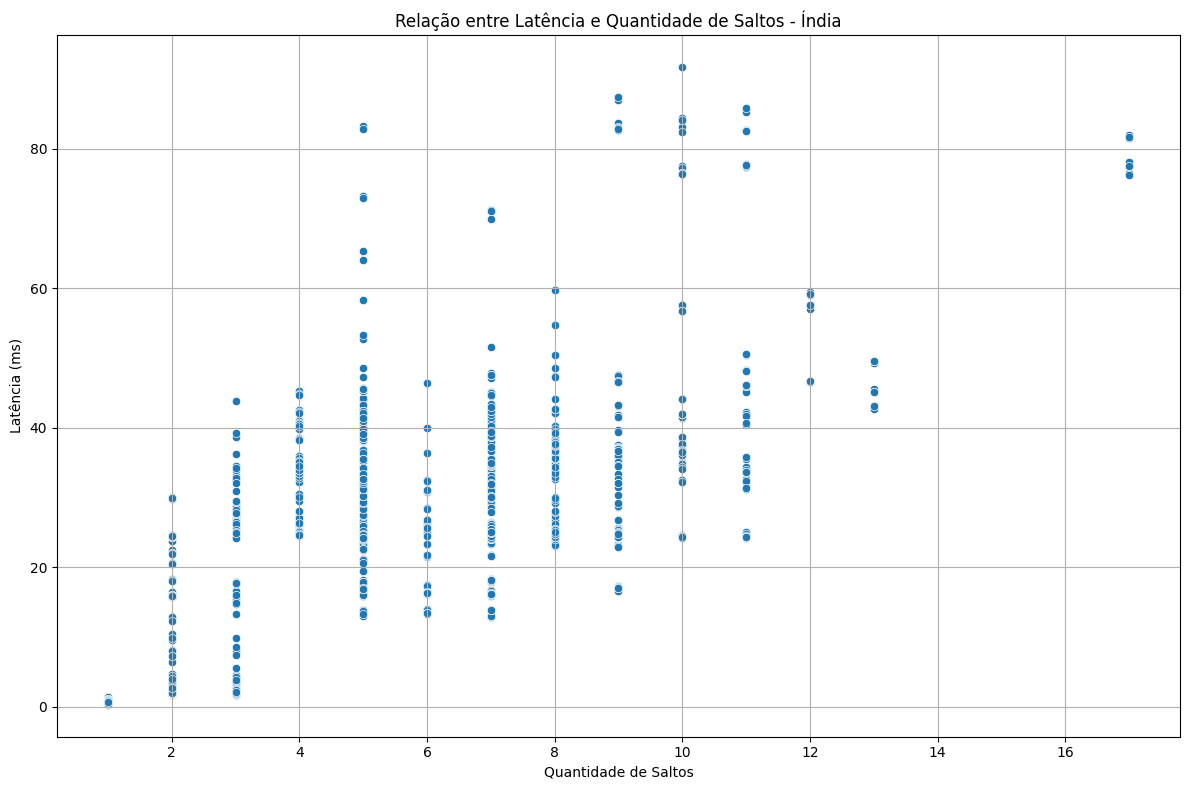

/tmp/ipykernel_36994/597357278.py:80: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H', on='timestamp').agg({


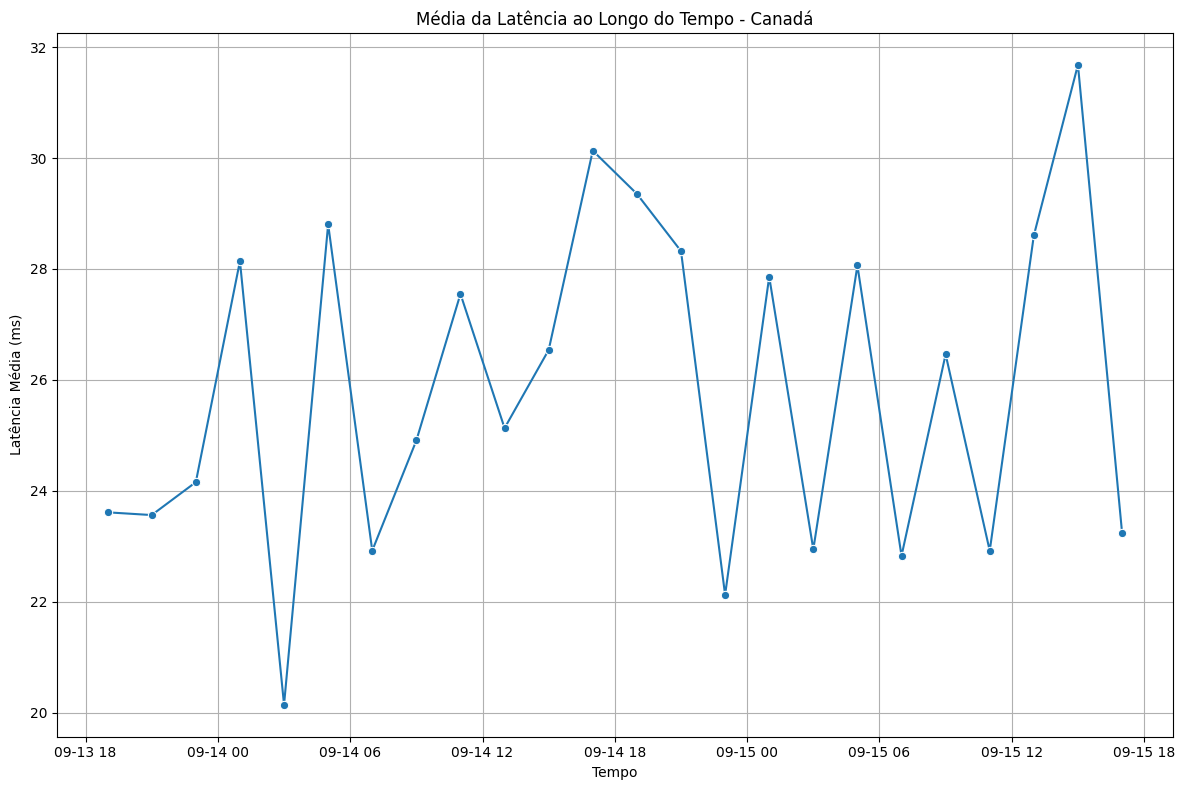

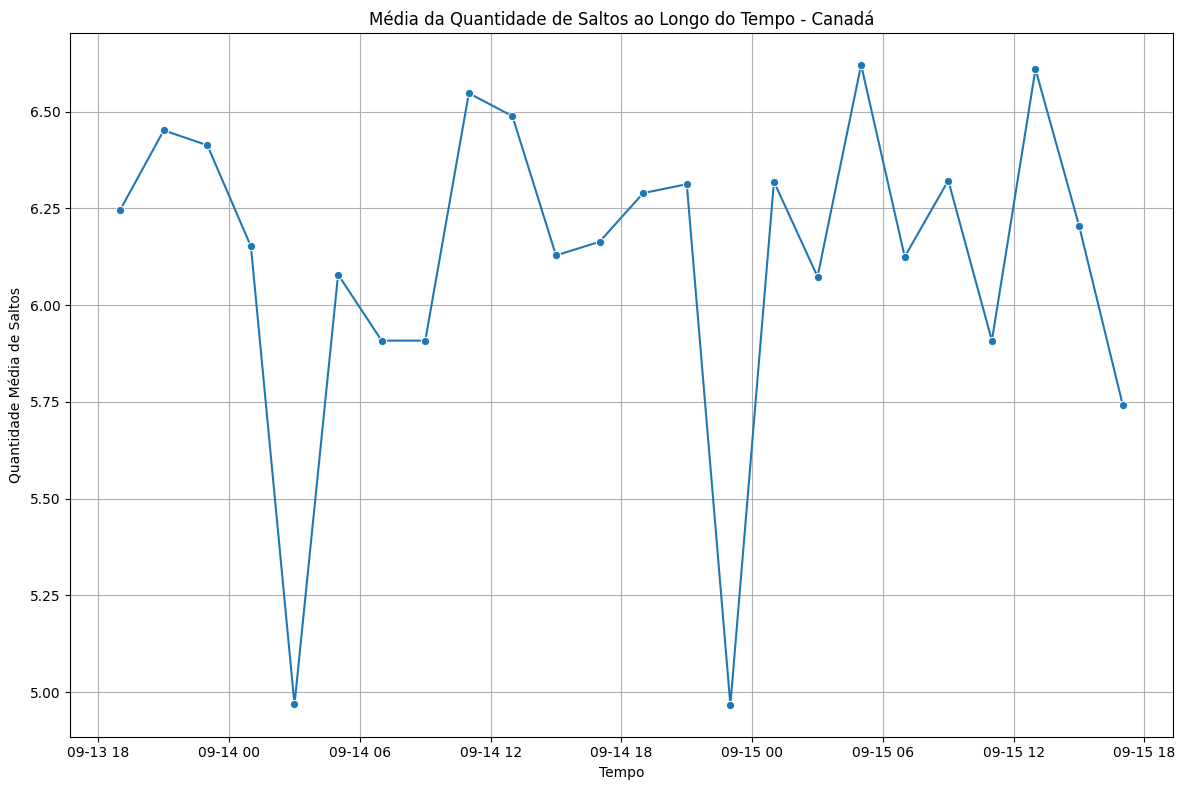

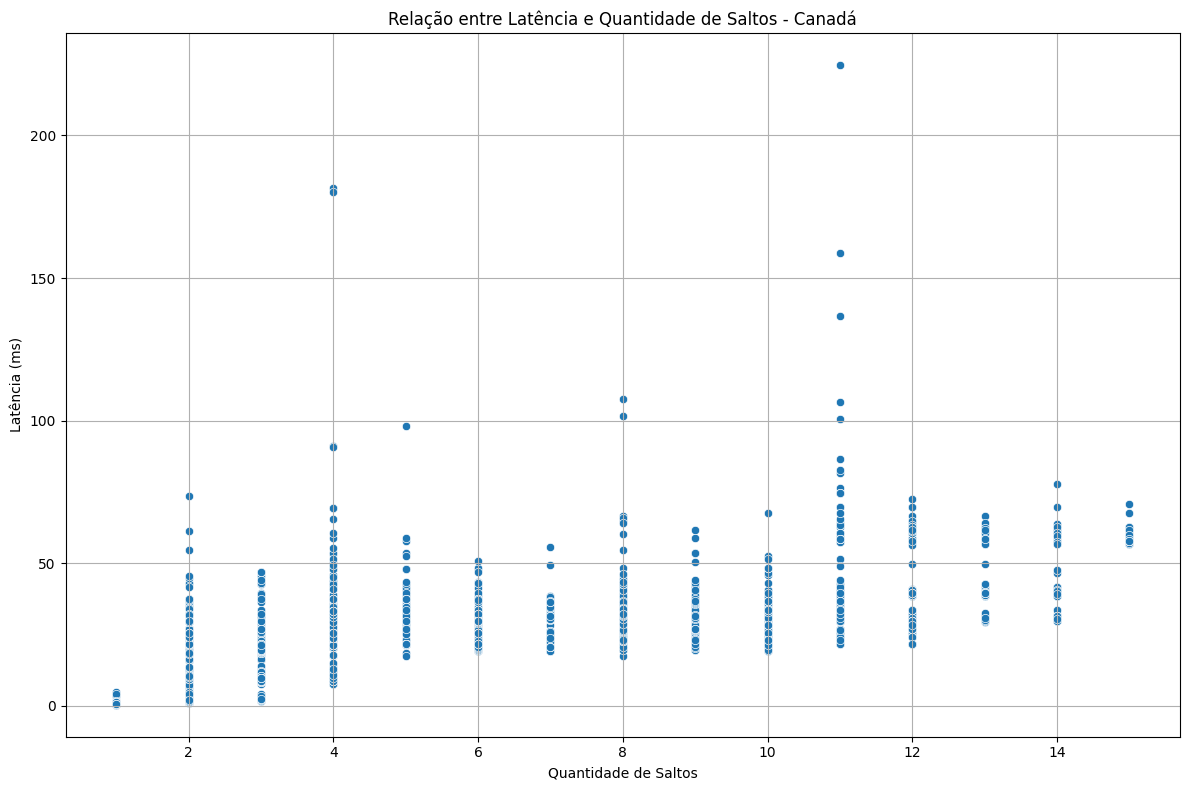

/tmp/ipykernel_36994/597357278.py:80: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H', on='timestamp').agg({


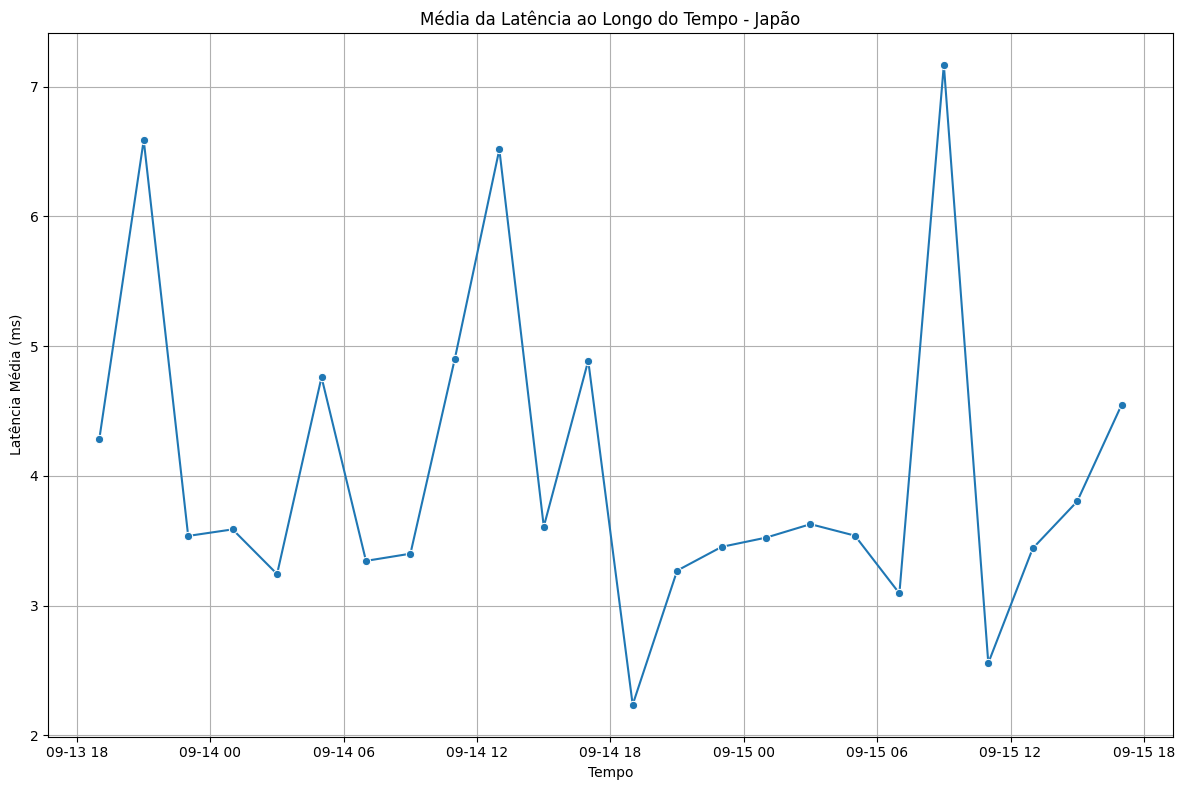

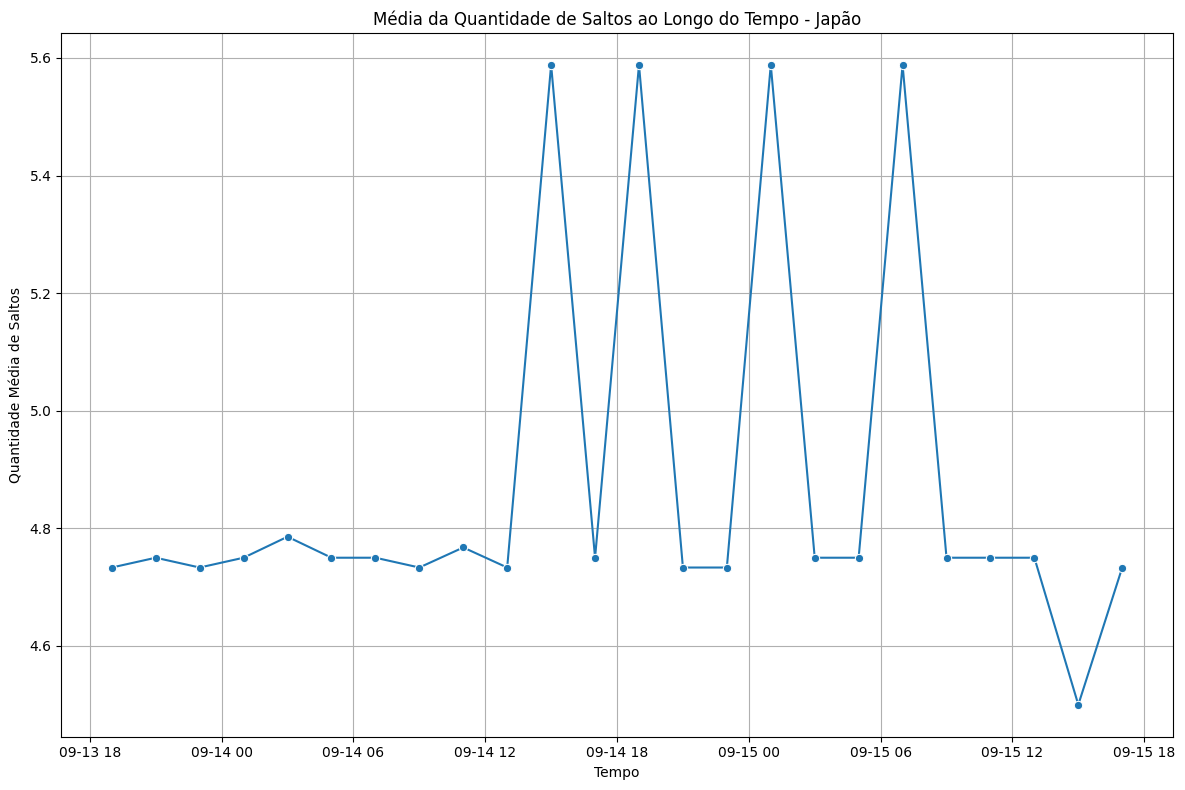

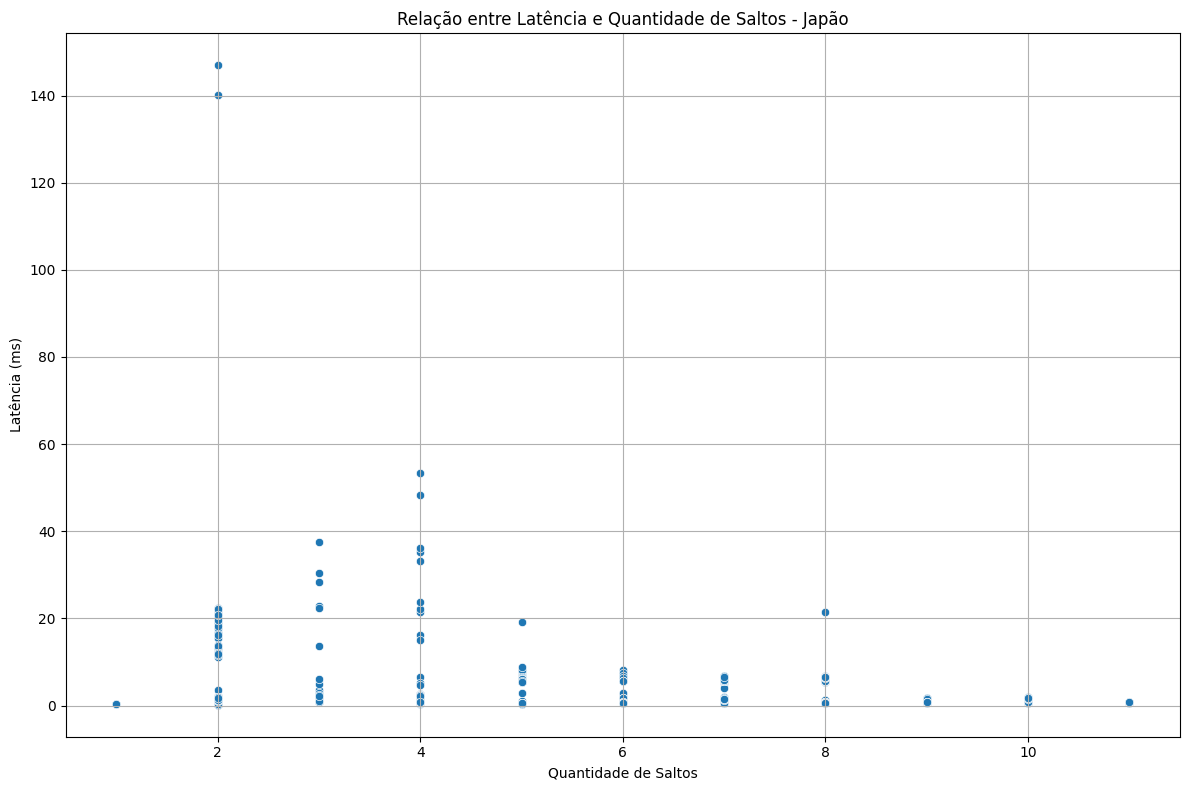

/tmp/ipykernel_36994/597357278.py:80: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H', on='timestamp').agg({


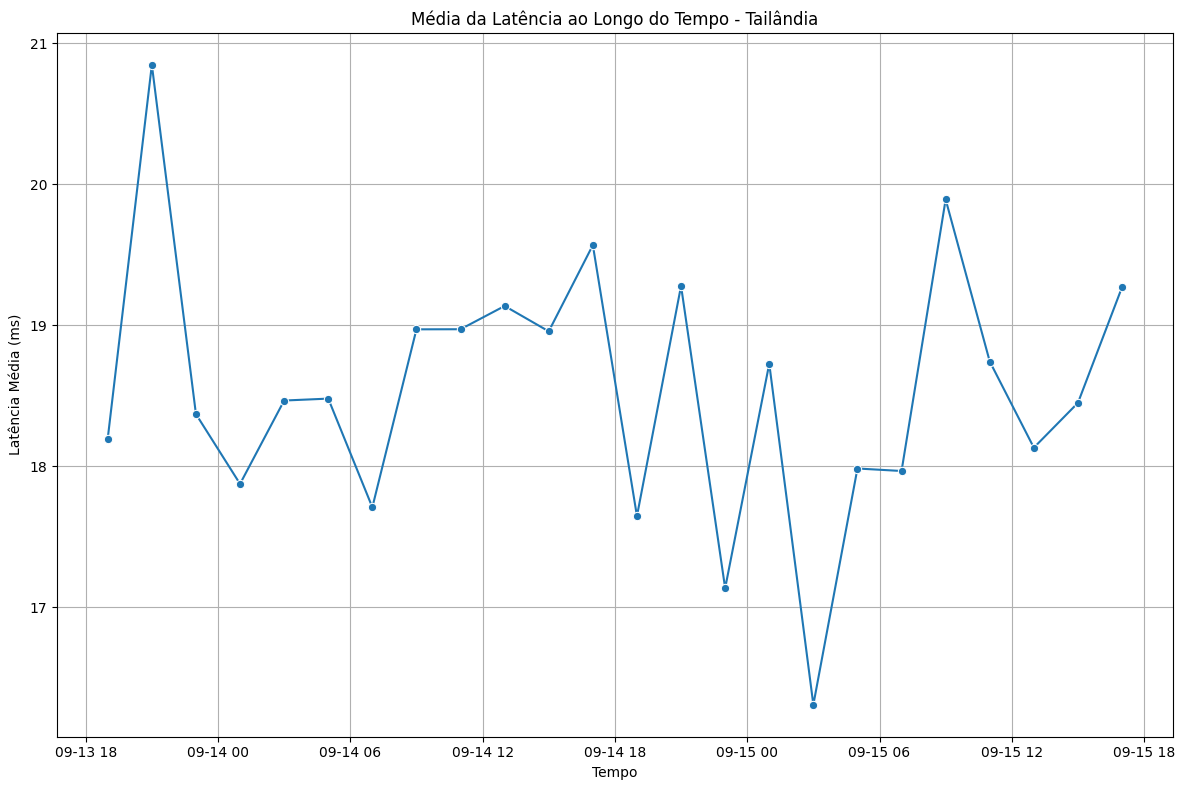

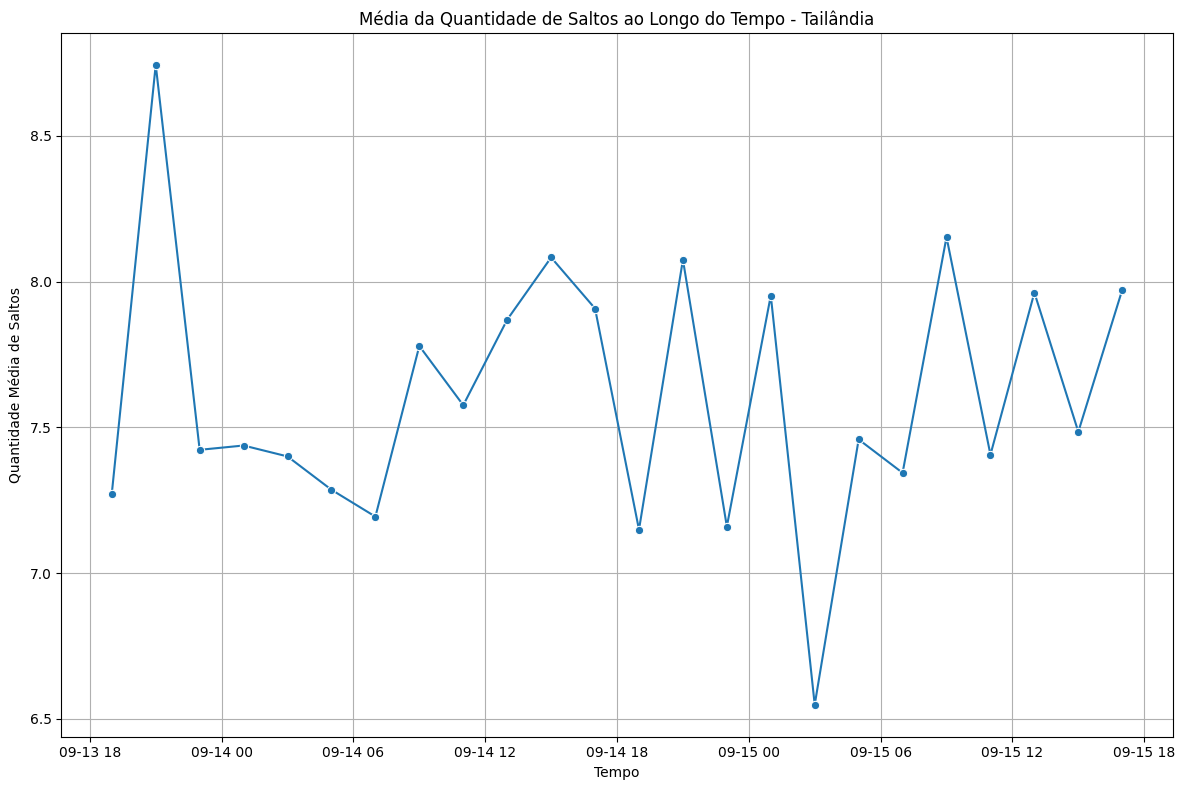

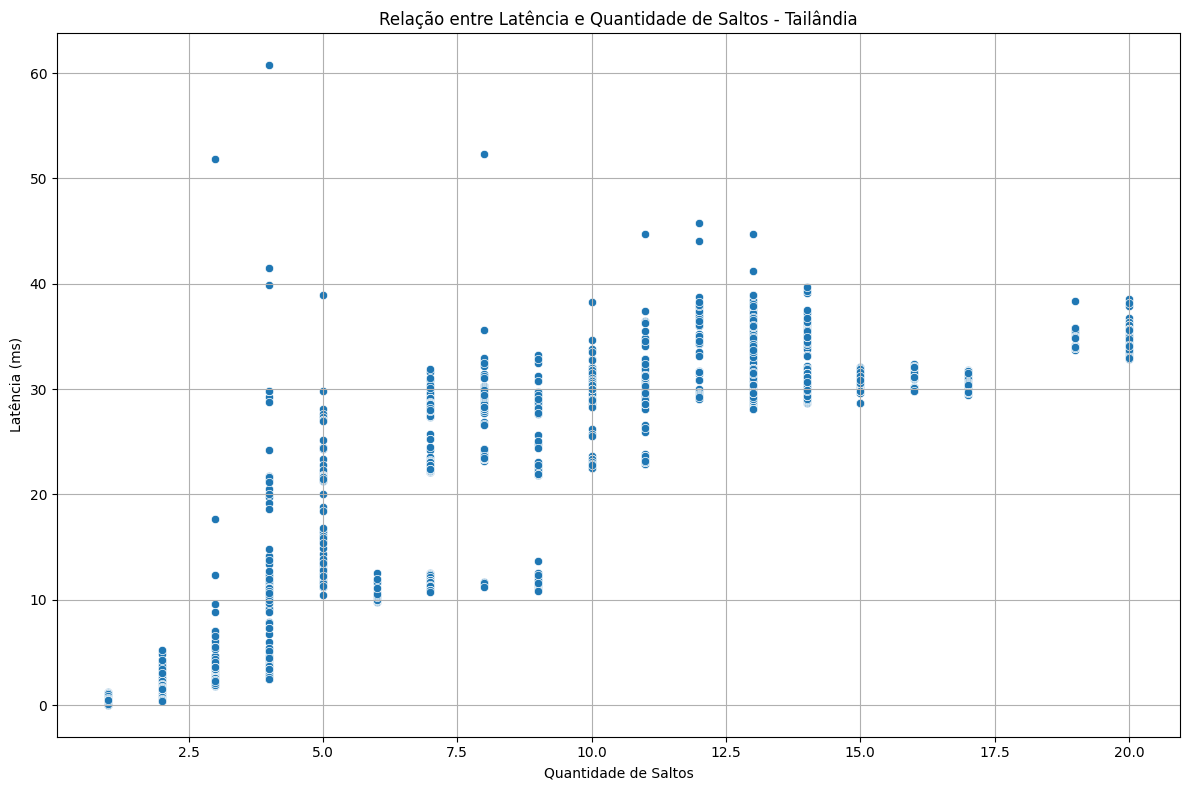

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import os

def getProbeCountry(probeId):
    return probesLocation.get(probeId, {}).get('país', f'ID {probeId} não encontrado')

def getProbeContinent(probeId):
    return probesLocation.get(probeId, {}).get('continente', f'ID {probeId} não encontrado')

def getLatency(probeInfo):
    latencias = []
    for hop in probeInfo['result']:
        latenciasHop = [item['rtt'] for item in hop['result'] if 'rtt' in item]
        latencias.append(latenciasHop)
    return latencias

pais = []
cod = []
probeGroupedInfo = {}

# Carregar dados JSON
with open('jsonFiles/GoogleNews.json', 'r') as jsonFile:
    resultInfo = json.load(jsonFile)

# Agrupar dados por país
for probeInfo in resultInfo['info']:
    if probeInfo["destination_ip_responded"]:
        probeJson = {
            'probeId': probeInfo['prb_id'],
            'destino': probeInfo['dst_name'],
            'pais': getProbeCountry(probeInfo['prb_id']),
            'continente': getProbeContinent(probeInfo['prb_id']),
            'latencia': getLatency(probeInfo),
            'quantidadeSaltos': len(probeInfo['result']),
            'data': datetime.fromtimestamp(probeInfo['stored_timestamp']).strftime('%Y-%m-%d %H:%M:%S')
        }
        
        if probeJson['pais'] not in probeGroupedInfo:
            probeGroupedInfo[probeJson['pais']] = []
        probeGroupedInfo[probeJson['pais']].append(probeJson)

# Criar diretório de saída
output_dir = 'imagensPais/GoogleNews'
os.makedirs(output_dir, exist_ok=True)

# Gerar gráficos para cada país
for pais in probeGroupedInfo:
    data = probeGroupedInfo[pais]

    # Preparar dados para DataFrame
    rows = []
    for measurement in data:
        probe_id = measurement['probeId']
        destination = measurement['destino']
        country = measurement['pais']
        continent = measurement['continente']
        timestamp = measurement['data']
        
        for hop_num, hop_latencies in enumerate(measurement['latencia'], start=1):
            if hop_latencies:
                for rtt in hop_latencies:
                    rows.append({
                        'probe_id': probe_id,
                        'destination': destination,
                        'country': country,
                        'continent': continent,
                        'timestamp': timestamp,
                        'hop': hop_num,
                        'rtt': rtt
                    })

    df = pd.DataFrame(rows)
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Agrupar por hora e calcular a média
    df_hourly = df.resample('H', on='timestamp').agg({
        'rtt': 'mean',
        'hop': 'mean'
    }).reset_index()

    # Plotar a média da latência ao longo do tempo por país
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_hourly, x='timestamp', y='rtt', marker='o')
    plt.title(f'Média da Latência ao Longo do Tempo - {pais}')
    plt.xlabel('Tempo')
    plt.ylabel('Latência Média (ms)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'latencia_por_tempo_{pais}.png'))
    plt.show()

    # Plotar a média da quantidade de saltos ao longo do tempo por país
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_hourly, x='timestamp', y='hop', marker='o')
    plt.title(f'Média da Quantidade de Saltos ao Longo do Tempo - {pais}')
    plt.xlabel('Tempo')
    plt.ylabel('Quantidade Média de Saltos')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'saltos_por_tempo_{pais}.png'))
    plt.show()

    # Plotar a relação entre latência e quantidade de saltos
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='hop', y='rtt')
    plt.title(f'Relação entre Latência e Quantidade de Saltos - {pais}')
    plt.xlabel('Quantidade de Saltos')
    plt.ylabel('Latência (ms)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'latencia_X_saltos_{pais}.png'))
    plt.show()
